In [33]:
!pip install eli5==0.13.0

# # 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

import geocode_concat as gc
import nearest_subway as ns
import nearest_bus_station as nbs
import predict_wage as pw

pd.set_option("display.max_rows", None)    # 행 생략 없음
pd.set_option("display.max_columns", None) # 열 생략 없음
pd.set_option("display.width", None)       # 줄바꿈 없이 가로로 다 출력
pd.set_option("display.max_colwidth", None) # 각 셀 내용 최대 길이 제한 없음

train_path = "~/apt-price/data/train.csv"
test_path = "~/apt-price/data/test.csv"
bus_path = "~/apt-price/data/bus_feature.csv"
subway_path = "~/apt-price/data/subway_feature.csv"

dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
bus_df = pd.read_csv(bus_path)
subway_df = pd.read_csv(subway_path)

# 데이터 shape 확인
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)
print('Bus data shape : ', bus_df.shape, 'Subway data shape : ', subway_df.shape)

# train과 test 구분을 위한 컬럼을 만들어주고 하나의 데이터로 합쳐줌
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test]) 
concat['is_test'].value_counts()

# 어려운 컬럼 이름 바꿔줌
concat = concat.rename(columns={'전용면적(㎡)':'전용면적', '좌표X':'경도', '좌표Y':'위도'})

# 집값과 전혀 상관 없을 것 같은 아래 변수들은 과감히 지워줌
concat.drop(columns=["해제사유발생일",
                    "등기신청일자",
                    "거래유형",
                    "중개사소재지",
                    "k-전화번호",
                    "k-팩스번호",
                    "단지소개기존clob",
                    "k-홈페이지",
                    "k-등록일자",
                    "k-수정일자",
                    "고용보험관리번호",
                    "단지승인일",
                    "관리비 업로드",
                    "단지신청일",
                    'k-사용검사일-사용승인일',
                    '사용허가여부',
                    '기타/의무/임대/임의=1/2/3/4',
                    '청소비관리형태',
                    '세대전기계약방법',
                    'k-관리방식',
                    'k-단지분류(아파트,주상복합등등)',
                    'k-시행사',
                    'k-복도유형',
                    'k-세대타입(분양형태)'], inplace=True)

# 본번, 부번 str 형태로 수정
concat_select = concat
concat['본번'] = concat['본번'].astype('str')
concat['부번'] = concat['부번'].astype('str')


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.
Train data shape :  (1118822, 52) Test data shape :  (9272, 51)
Bus data shape :  (12584, 6) Subway data shape :  (768, 5)


In [34]:
# 지오코딩으로 위도, 경도 채워주기
# concat_select2 = gc.geocode_concat_and_save_fast(
#     df=concat_select,           # or concat_select
#     sigungu_col="시군구",
#     bunji_col="번지",
#     output_csv="concat_select2_with_geo.csv",
#     sleep_sec=0.10               # 조금 더 빠르게; 필요시 0.08~0.12 조절
# )

In [35]:
# 너무 오래 걸리므로 미리 만들어놓음
new_concat_select_path = "concat_select2_with_geo.csv"

concat_select = pd.read_csv(new_concat_select_path)

In [36]:
# concat_select에서 기존에 있었던 경도, 위도 컬럼 삭제하고 새로운 위도 경도 컬럼 이름 변경
concat_select.drop(columns=["경도",
                    "위도"], inplace=True)

concat_select = concat_select.rename(columns={'geo_lat':'위도', 'geo_lon':'경도'})

In [37]:
# # 지하철역 피처 추가
# concat_select2 = ns.add_subway_features(
#     concat_select, subway_df,
#     lat_col="위도", lon_col="경도",
#     sub_lat_col="위도", sub_lon_col="경도",
#     sub_name_col="역사명",
#     out_csv="concat_select2_with_subway.csv"
# )
# 
# # 너무 오래 걸리므로 미리 만들어놓음
# concat_select2_with_subway_path = "concat_select2_with_subway.csv"

# concat_select = pd.read_csv(concat_select2_with_subway_path)

In [38]:
# # 버스정류장 피처 추가
# concat_select2 = nbs.add_bus_features(
#     concat_select2, bus_df,
#     lat_col="위도", lon_col="경도",
#     bus_lat_col="Y좌표", bus_lon_col="X좌표",
#     bus_name_col="정류소명",
#     out_csv="concat_select2_with_bus.csv",
#     verbose=True
# )

# 너무 오래 걸리므로 미리 만들어놓음
concat_select2_with_bus_path = "concat_select2_with_bus.csv"

concat_select = pd.read_csv(concat_select2_with_bus_path)

In [39]:
concat_select.head(1).T

,0
시군구,서울특별시 강남구 개포동
번지,658-1
본번,658.0
부번,1.0
아파트명,개포6차우성
전용면적,79.97
계약년월,201712
계약일,8
층,3
건축년도,1987


In [40]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
# del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
# del concat_select['계약년월']

In [41]:
# 시·군·구별 근로소득 연말정산 신고현황(주소지) [2016~]
average_wage_path = "average_wage.csv"

average_wage = pd.read_csv(average_wage_path, encoding="cp949")
average_wage = pw.predict_by_district_linear(average_wage, years_to_predict=(2023, 2024),
                                 district_col=None,)  # 구 컬럼명이 있으면 '구' 등으로 지정

average_wage.head()

,구,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,강남구,63180018.19,70288947.65,69642773.22,71197783.96,74687708.89,81053206.39,84195799.24,86266719,89467462
1,강동구,34693920.43,36321654.16,38071813.27,40510555.78,41596165.03,44191867.97,46063056.08,47831603,49737752
2,강북구,25896302.16,27069900.21,28179686.82,29282999.29,29528033.35,31041122.77,33040920.00,33537659,34634967
3,강서구,33018423.11,34824475.79,36323784.82,37389156.60,37465235.23,39478474.30,42341790.97,42751556,44123683
4,관악구,28584082.22,29703509.07,30757579.62,31568163.95,32071817.20,33653263.62,35853226.54,36173260,37281160


In [42]:
import gc
gc.collect()

13

In [43]:
import wage_feature_engineering as wfe

concat_select = wfe.add_income_derived_features_simple(
    concat_select,
    average_wage,
    gu_col="구",
    year_col="계약년",
    year_min=2016, year_max=2024
)

concat_select.head(1).T
# new_cols = ["wage","wage_log1p","rel_gap","z_score","rank_pct","yoy","cagr3","accel","vol3","trend_beta3","gap_from_city_trend"]
# print([c for c in new_cols if c in concat_select2.columns][:8], "...")

,0
시군구,서울특별시 강남구 개포동
번지,658-1
본번,658.0
부번,1.0
아파트명,개포6차우성
전용면적,79.97
계약년월,201712
계약일,8
층,3
건축년도,1987


In [44]:
# 연속형 변수와 범주형 변수 분리
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', '위도', '경도', 'subway_dist_m', 'subway_walk_min', 'subway_cnt_300m', 'subway_cnt_500m', 'subway_cnt_1000m', 'bus_dist_m', 'bus_walk_min', 'bus_cnt_200m', 'bus_cnt_300m', 'bus_cnt_500m', 'bus_cnt_1000m', 'year', 'year_clip', 'wage', 'wage_log1p', 'rel_gap', 'z_score', 'rank_pct', 'yoy', 'cagr3', 'accel', 'vol3', 'trend_beta3']
범주형 변수: ['시군구', '번지', '아파트명', '도로명', 'k-난방방식', 'k-건설사(시공사)', '경비비관리형태', 'subway_nearest_name', 'bus_nearest_name', '구', '동', '계약년', '계약월', '구_std']


In [45]:
# 범주형 변수는 null을 채워서 보간해줌
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

In [46]:
concat_select[continuous_columns].isnull().sum()

본번                             75
부번                             75
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
k-전체동수                     877207
k-전체세대수                    876125
k-연면적                      876125
k-주거전용면적                   876170
k-관리비부과면적                  876125
k-전용면적별세대현황(60㎡이하)         876170
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-85㎡~135㎡이하               876170
k-135㎡초과                  1127765
건축면적                       876279
주차대수                       876277
target                       9272
is_test                         0
위도                          17529
경도                          17529
subway_dist_m               17529
subway_walk_min             17529
subway_cnt_300m             17529
subway_cnt_500m             17529
subway_cnt_1000m            17529
bus_dist_m                  17529
bus_walk_min                17529
bus_cnt_200m  

In [47]:
# 연속형 변수는 어떻게 보간할까...
# 단지 키(시군구+도로명+아파트명+건축년도)를 만들고 같은 단지 내 관측들에서 median 값으로 채우자
concat_select["complex_key"] = (
    concat_select["시군구"].astype(str).str.strip() + "|" +
    concat_select["번지"].astype(str).str.strip() + "|" +
    concat_select["아파트명"].astype(str).str.strip() + "|" +
    concat_select["건축년도"].astype(str).str.strip()
)

concat_select[continuous_columns].isna().mean().sort_values(ascending=False)

k-135㎡초과                  0.999708
k-전체동수                    0.777601
건축면적                      0.776778
주차대수                      0.776777
k-전용면적별세대현황(60㎡이하)        0.776682
k-주거전용면적                  0.776682
k-전용면적별세대현황(60㎡~85㎡이하)    0.776682
k-85㎡~135㎡이하              0.776682
k-전체세대수                   0.776642
k-연면적                     0.776642
k-관리비부과면적                 0.776642
subway_walk_min           0.015539
subway_cnt_1000m          0.015539
경도                        0.015539
위도                        0.015539
bus_dist_m                0.015539
subway_dist_m             0.015539
subway_cnt_500m           0.015539
bus_walk_min              0.015539
bus_cnt_200m              0.015539
bus_cnt_300m              0.015539
bus_cnt_500m              0.015539
bus_cnt_1000m             0.015539
subway_cnt_300m           0.015539
target                    0.008219
본번                        0.000066
부번                        0.000066
wage_log1p                0.000000
vol3                

In [48]:

def _fill_by_group_median(df, col, group_cols):
    # group_cols 순서대로 내려가며 채우기
    s = df[col]
    for gcols in group_cols:
        med = df.groupby(gcols)[col].transform("median")
        s = s.fillna(med)
    return s

group_levels = [
    ["complex_key"],                # 같은 단지
    ["시군구","아파트명"],             # 같은 시군구의 같은 아파트명
    ["시군구"],                      # 같은 시군구
]

for col in continuous_columns:
    if col not in concat_select.columns: 
        continue
    was_na = concat_select[col].isna()
    concat_select[col] = _fill_by_group_median(concat_select, col, group_levels)
    # 전역 중앙값으로 최종 백업
    concat_select[col] = concat_select[col].fillna(concat_select[col].median())
    

In [ ]:
# - 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.
all = list(concat_select['구'].unique())
gangnam = ['강남구', '서초구', '송파구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

# - 한강과 맞닿은 구인지 여부에 따라 파생변수를 생성해주도록 하겠습니다.
hangang = ['양천구', '영등포구', '동작구', '마포구', '용산구', '성동구', '강남구', '서초구', '송파구', '광진구']
no_hangang = [x for x in all if x not in hangang]

assert len(all) == len(hangang) + len(no_hangang)       # 알맞게 분리되었는지 체크합니다.
# 강남의 여부를 체크합니다.
is_hangang = []
for x in concat_select['구'].tolist() :
  if x in hangang :
    is_hangang.append(1)
  else :
    is_hangang.append(0)

# 파생변수를 하나 만듭니다.
concat_select['한강여부'] = is_hangang

# 가중치 값 설정 ==========> 가중치 넣으니까 점수 더 떨어짐
# w_gn = 3.0   # 강남 여부 가중치
# w_hg = 2.0   # 한강 여부 가중치
# concat_select["강남여부_weighted"] = concat_select["강남여부"] * w_gn
# concat_select["한강여부_weighted"] = concat_select["한강여부"] * w_hg

# --- 상호작용(필요시 더 추가) ---
if '전용면적' in concat_select.columns:
    concat_select['강남x전용면적'] = concat_select['강남여부'] * concat_select['전용면적']
    concat_select['한강x전용면적'] = concat_select['한강여부'] * concat_select['전용면적']
# concat_select['강남x한강'] = concat_select['강남여부'] * concat_select['한강여부']


# - 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
# - 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)
concat_select.head(1).T       # 최종 데이터셋은 아래와 같습니다.


,0
시군구,서울특별시 강남구 개포동
번지,658-1
본번,658.0
부번,1.0
아파트명,개포6차우성
전용면적,79.97
계약년월,201712
계약일,8
층,3
건축년도,1987


In [50]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)
dt_test.head(1)
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))



(1118822, 64) (9272, 64)
연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', 'target', '위도', '경도', 'subway_dist_m', 'subway_walk_min', 'subway_cnt_300m', 'subway_cnt_500m', 'subway_cnt_1000m', 'bus_dist_m', 'bus_walk_min', 'bus_cnt_200m', 'bus_cnt_300m', 'bus_cnt_500m', 'bus_cnt_1000m', 'year', 'year_clip', 'wage', 'wage_log1p', 'rel_gap', 'z_score', 'rank_pct', 'yoy', 'cagr3', 'accel', 'vol3', 'trend_beta3', '강남여부', '한강여부', '강남x전용면적', '한강x전용면적', '신축여부']
범주형 변수: ['시군구', '번지', '아파트명', '도로명', 'k-난방방식', 'k-건설사(시공사)', '경비비관리형태', 'subway_nearest_name', 'bus_nearest_name', '구', '동', '계약년', '계약월', '구_std', 'complex_key']


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


In [51]:
assert dt_train.shape[1] == dt_test.shape[1] 

In [52]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [53]:
import re
import pandas as pd

def make_safe_columns(df: pd.DataFrame):
    # 1) 특수문자 -> '_' 치환
    safe = [re.sub(r'[^\w]+', '_', str(c)).strip('_') for c in df.columns]
    # 2) 빈 이름/중복 처리
    seen = {}
    new_cols = []
    for s in safe:
        if s == '':
            s = 'col'
        if s in seen:
            seen[s] += 1
            s = f"{s}_{seen[s]}"
        else:
            seen[s] = 0
        new_cols.append(s)
    mapping = dict(zip(df.columns, new_cols))
    return df.rename(columns=mapping), mapping

# 전처리 끝난 데이터프레임들에 적용
X_train, map_tr = make_safe_columns(X_train)
X_val   = X_val.rename(columns=map_tr)
# (있다면) X_test도 동일 매핑 적용
# X_test  = X_test.rename(columns=map_tr)


In [54]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

params = dict(
    objective="regression",
    metric="rmse",
    boosting_type="gbdt",
    learning_rate=0.03,
    num_leaves=63,
    min_data_in_leaf=30,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l2=1.0,
    n_estimators=10000,
    random_state=42,
    verbosity=-1,
)

model = lgb.LGBMRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)],
)

pred_val = model.predict(X_val)
rmse = mean_squared_error(y_val, pred_val, squared=False)
print(f"Valid RMSE: {rmse:.6f}")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 14008.1
[200]	valid_0's rmse: 10816.3
[300]	valid_0's rmse: 9508.8
[400]	valid_0's rmse: 8791.29
[500]	valid_0's rmse: 8328.08
[600]	valid_0's rmse: 7989.67
[700]	valid_0's rmse: 7713.77
[800]	valid_0's rmse: 7495.28
[900]	valid_0's rmse: 7313.94
[1000]	valid_0's rmse: 7158.83
[1100]	valid_0's rmse: 7027.7
[1200]	valid_0's rmse: 6914.29
[1300]	valid_0's rmse: 6811.2
[1400]	valid_0's rmse: 6722.95
[1500]	valid_0's rmse: 6642.48
[1600]	valid_0's rmse: 6573.85
[1700]	valid_0's rmse: 6509.45
[1800]	valid_0's rmse: 6455.23
[1900]	valid_0's rmse: 6414.24
[2000]	valid_0's rmse: 6365.28
[2100]	valid_0's rmse: 6317.62
[2200]	valid_0's rmse: 6277.84
[2300]	valid_0's rmse: 6238.95
[2400]	valid_0's rmse: 6203.97
[2500]	valid_0's rmse: 6170.69
[2600]	valid_0's rmse: 6145.08
[2700]	valid_0's rmse: 6121.76
[2800]	valid_0's rmse: 6094.31
[2900]	valid_0's rmse: 6070.43
[3000]	valid_0's rmse: 6044.38
[3100]	valid_0's rms

In [60]:
with open('lightgbm_transportation_ver_model3.pkl', 'wb') as f:
    pickle.dump(model, f)

In [61]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 13.8 s, sys: 1e+03 ns, total: 13.8 s
Wall time: 1.53 s


In [62]:
real_test_pred

array([186388.1268877 , 301899.57107137, 302915.28964849, ...,
        79995.69810087,  71152.78448795,  70759.61649515])

In [63]:
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('../outputs/output12.csv', index=False)

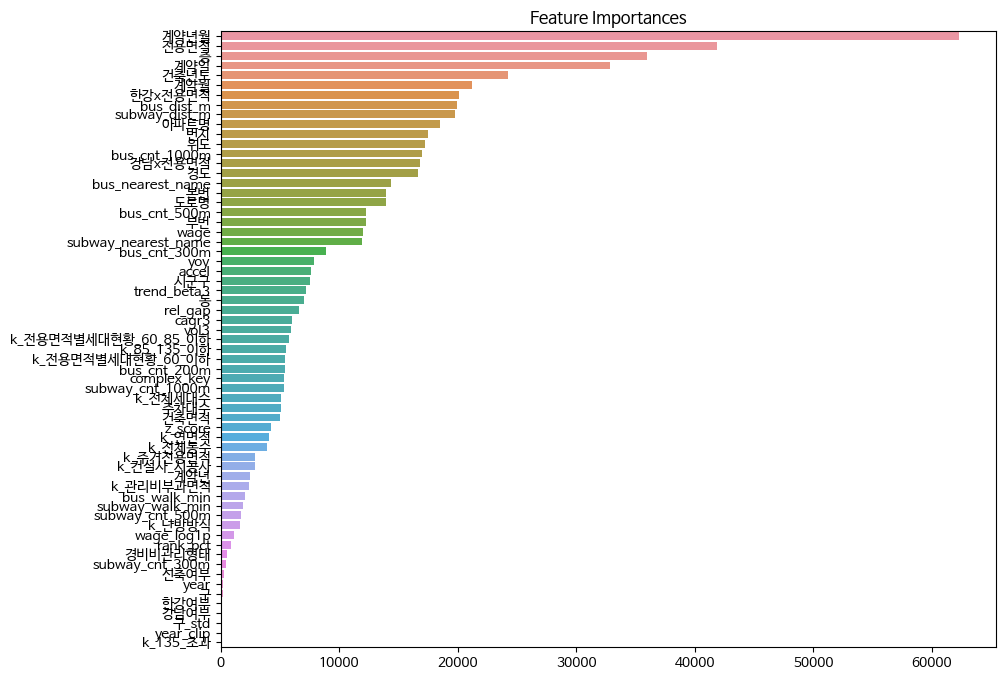

In [64]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()